In [315]:
%matplotlib inline
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

In [326]:
sys.path.append(os.path.realpath('..'))

avail_data_file = "hourly-avg-2017-06-all-stations.csv"
weather_data_file = "fmi-weatherdata-Helsinki-Kaisaniemi-2017.csv"

In [327]:
# Read and combine data
bikeData = pd.read_csv(avail_data_file, sep=',')
weatherData = pd.read_csv(weather_data_file, sep=",")

weatherData.rename(columns={'Vuosi': 'Year', 'Kk': 'Month', 'Pv': 'Day', 'Klo': 'Time', 'Aikavyöhyke': 'Timezone', 'Sateen intensiteetti (mm/h)': 'rainIntensity_mmh', 'Ilman lämpötila (degC)': 'temperature_c'}, inplace=True)  

In [328]:
# Filter only June 2017
weatherData = weatherData[weatherData.Month == 6]

# Reset dataframe indices to make combining work properly
bikeData = bikeData.reset_index(drop=True)
weatherData = weatherData.reset_index(drop=True)

bikeData['rainIntensity_mmh'] = weatherData['rainIntensity_mmh']
bikeData['temperature_c'] = weatherData['temperature_c']

In [344]:
# Assigning 'sumofhourlyavg' as the dependent variable y
# Assigning 'Sade' and 'Ilman_lampotila' as independent variables X (X is 2xn matrix here but it will still need the weekday-info and hour-columns to be complete)
X = bikeData.loc[:, ['rainIntensity_mmh','temperature_c']] # matrix of independent variables 'rainIntensity_mmh' and 'temperature_c'
y = bikeData[bikeData.columns[1]] # vector of 'sumofhourlyavg'

# Add hour to the matrix of independent variables
bikeData['hour'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)

# Add month to the matrix of independent variables
#X['month'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)

# Add weekday to the matrix of independent variables. 0 is Monday, 6 is Sunday.
#X['weekday'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())

# Investigating weekday, I found that some variance was explained by it, but _very_ little
bikeData['weekday'] = bikeData['timehour'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").weekday())

# Applied moving average to transform the data (rainIntensity) with 8 hours history 
bikeData['rain_MA'] = np.zeros(len(bikeData['sumofhourlyavg']))
moving_average_window_size = 8

for i in range(len(weatherData['rainIntensity_mmh'])):
    avg_val = 0
    sum_count = 0
    for j in range(moving_average_window_size):
        if (i-j >= 0):
            avg_val += weatherData['rainIntensity_mmh'].values[i-j] # moving average
            sum_count += 1
    avg_val /= sum_count
    bikeData['rain_MA'].values[i] = avg_val

drop_indices = []
for i in range(len(bikeData['rain_MA'])):
    if (bikeData['rain_MA'][i] == 0):
        drop_indices = drop_indices+[i]

# zero values are dropped here so that only points with recent rain appear on the scatterplot
bikeData['rain_MA'] = bikeData['rain_MA'].drop(labels=drop_indices)

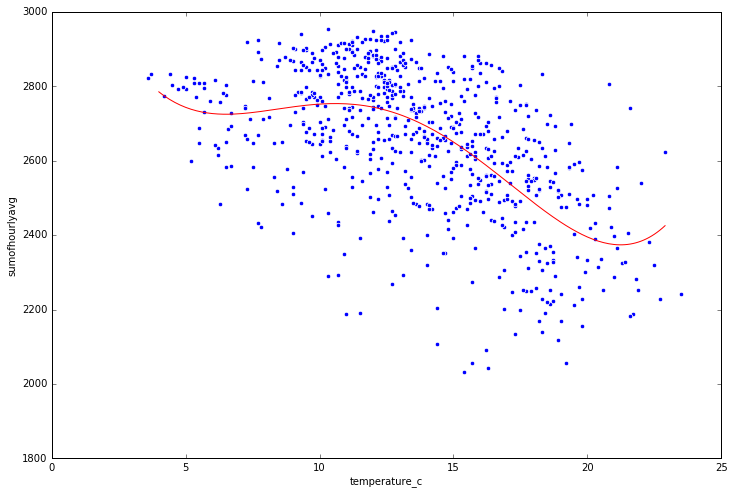

In [362]:
# finding indices where rain_MA is finite (meaning, where rain_MA is non-zero)
rain_idx = np.isfinite(bikeData['rain_MA'].values) & np.isfinite(bikeData['sumofhourlyavg'].values)

# fitting polynomials to each input dataset in relation to the aggregate bike availability
# NOTE: when making station-wise, each station needs 3 of its own sets of coefficients in relation to that station's bike-availability
p_coeffsTemp = np.polyfit(bikeData['temperature_c'].values, bikeData['sumofhourlyavg'].values, 4)
p_coeffsRain = np.polyfit(bikeData['rain_MA'].values[rain_idx], bikeData['sumofhourlyavg'].values[rain_idx], 2)
p_coeffsHours = np.polyfit(bikeData['hour'].values, bikeData['sumofhourlyavg'].values, 3)

xx_temp = np.arange(4,23,0.1)
yy_temp = np.zeros(len(xx_temp))
for i in range(len(xx_temp)):
    yy_temp[i] = np.polyval(p_coeffsTemp, xx_temp[i])

xx_rain = np.arange(0, 3.02, 0.02)
yy_rain = np.zeros(len(xx_rain))
for i in range(len(xx_rain)):
    yy_rain[i] = np.polyval(p_coeffsRain, xx_rain[i])
    
xx_hour = np.arange(0, 24, 1)
yy_hour = np.zeros(len(xx_hour))
for i in range(len(xx_hour)):
    yy_hour[i] = np.polyval(p_coeffsHours, xx_hour[i])
    

# Producing three scatterplots to investigate the relationships: availability vs. temperature, availability vs. precipitation, availability vs. hour of the day
fig, ax = plt.subplots(1, 1, figsize=(12,8))
aax = sns.scatterplot(x='temperature_c', y='sumofhourlyavg', data=bikeData)
plt.plot(xx_temp, yy_temp,'r')

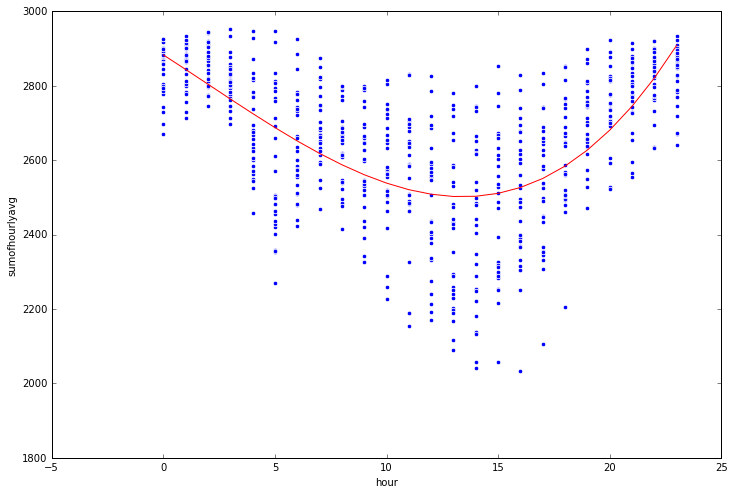

In [363]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ddx = sns.scatterplot(x=bikeData['hour'], y=bikeData['sumofhourlyavg']) # hour of the day
plt.plot(xx_hour, yy_hour,'r')

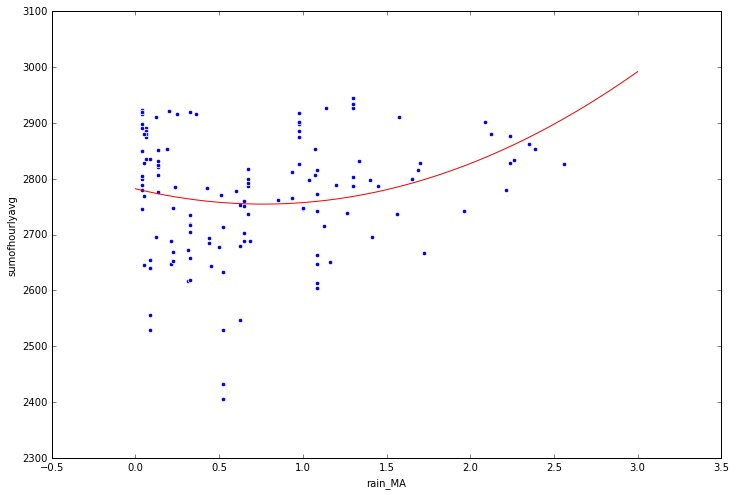

In [364]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
bx = sns.scatterplot(x='rain_MA', y='sumofhourlyavg', data=bikeData)
plt.plot(xx_rain, yy_rain,'r')

Coefficient of determination (R^2): 0.607939261887


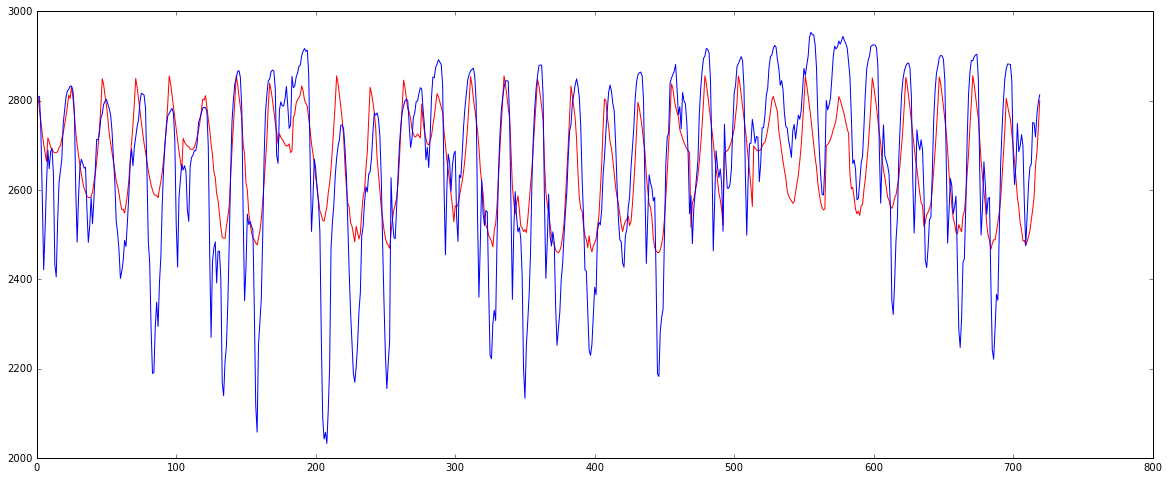

In [354]:
# Conditional mixed model, combining n:th order polynomial predictors as a weighted sum (with special conditions for recent rain)
bikeData['y_hat'] = np.zeros(len(bikeData['sumofhourlyavg']))
for i in range(len(bikeData['sumofhourlyavg'])):
    if (np.isnan(bikeData['rain_MA'].values[i])):
        temp_val = np.polyval(p_coeffsTemp, bikeData['temperature_c'].values[i])
        hour_val = np.polyval(p_coeffsHours, bikeData['hour'].values[i])
        bikeData['y_hat'].values[i] = 0.34*temp_val + 0.66*hour_val
    else:
        rain_val = np.polyval(p_coeffsRain, bikeData['rain_MA'].values[i])
        hour_val = np.polyval(p_coeffsHours, bikeData['hour'].values[i])
        bikeData['y_hat'].values[i] = 0.71*rain_val + 0.29*hour_val

# NOTE: the coefficients used above were determined experimentally. It's likely that every station would do best with custom coefficients.
# We can move forward with these hardcoded coefficients but we may look into mathematical optimization of these coefficients for every station.
    
# creating R**2, which is the 'Coefficient of Determination':
corr = np.corrcoef(bikeData['y_hat'].values, bikeData['sumofhourlyavg'].values)
coeff_determination = corr[0][1]**2

print('Coefficient of determination (R^2):', coeff_determination)

fig, ax = plt.subplots(1, 1, figsize=(20,8))

# Predicted availability is the red line and the observed availability is the blue line
plt.plot(range(len(bikeData['sumofhourlyavg'])), bikeData['y_hat'], 'r', label='predicted availability')
plt.plot(range(len(bikeData['sumofhourlyavg'])), bikeData['sumofhourlyavg'], 'b', label='observed availability')

#0.357180251752 Only Temperature predictor
#0.367322958164 Temperature predictor used when no recent rain, Rain predictor used when rain happened recently
#0.607939261887 Temperature and hour predictors used when no recent rain, rain and hour predictors when rain happened recently 

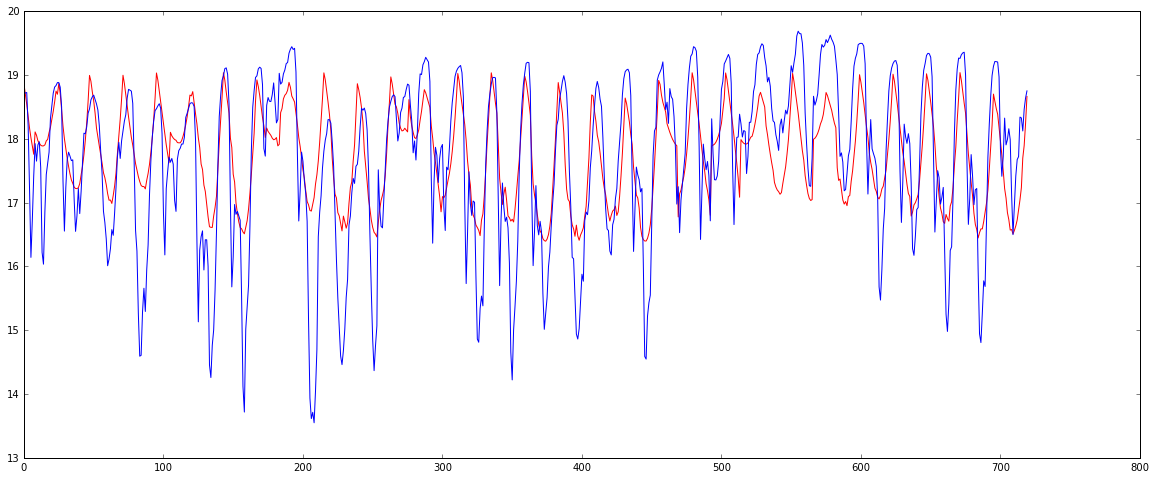

In [355]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
# prediction of bike-availability for the average station
# NOTE: should have much more interesting predicting power when done for each station
plt.plot(range(len(bikeData['sumofhourlyavg'])), bikeData['y_hat']/150, 'r', label='predicted availability')
plt.plot(range(len(bikeData['sumofhourlyavg'])), bikeData['sumofhourlyavg']/150, 'b', label='observed availability')




In [335]:
# exporting the predictions to a csv-file
bikeData.to_csv(r'/home/lea/anaconda3/projects/IntroToDS/y_hat.csv', sep=",")